# #0. Import packages for visualization (not used in a pipeline)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# #1. Code for similarity estimation

## #1.0. Import packages

In [2]:
import os
import argparse
import numpy as np
import pandas as pd

from math import log10 as lg
from scipy.stats import hypergeom
from tqdm import tqdm

## #1.1. Read GFF

Contains information about loci (about clans and clusters, we focus on clans)

In [3]:
# read gff
def _split_attributes(attrs: str):
    pairs = attrs.split(';')
    kvs = [pair.split('=', maxsplit=1) for pair in pairs]
    for i, kv in enumerate(kvs):
        if len(kv) == 1:
            kvs[i - 1][-1] += f'{kv[0]}'
            kvs.remove(kv)
    return {f'ATTRIBUTE_{k}': v for k, v in kvs}


def unites_attributes_col(row: pd.DataFrame, attribute_cols: pd.Index) -> str:
    attributes = []
    for attribute_name in attribute_cols:
        if row[attribute_name] is not nan:
            suffix = '_'.join(attribute_name.split('_')[1:])
            attributes.append(f'{suffix}={row[attribute_name]}')

    return ';'.join(attributes)


def read_gff(gff_path):
    """
    reads gff file into pd dataframe
    :param gff_path: (str) path to gff file
    :return: pd.DataFrame from gff file
    """
    colnames = ['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    entries = []
    with open(gff_path, 'rt') as gff:
        for line in gff:
            entry = line.strip().split('\t')
            entries.append(entry)

    gff_data = pd.DataFrame(entries, columns=colnames)
    gff_data['attribute_dict'] = gff_data['attributes'].apply(_split_attributes)

    norm_attribute = pd.json_normalize(gff_data.attribute_dict)
    gff_data = pd.concat([gff_data, norm_attribute], axis=1)
    # remove temp columns:
    gff_data = gff_data.drop(columns=['attribute_dict', 'attributes'])
    return gff_data

## #1.2. Calculate initial information about dataset

1) total clans number,
2) total number of comparisons

In [4]:
def calculate_total_clan_number(initial_gff_df):
    return len(initial_gff_df['ATTRIBUTE_clan'].unique())


def get_num_of_comparisons(initial_gff_df):
    n = len(initial_gff_df['seq_id'].unique())
    t = n * (n - 1)
    return t

## #1.3. Calculate similarity for each pair of loci

In [5]:
# calculate similarity
def get_intersect_len(set1, set2):
    return len(set1 & set2)


def get_prob(c, n, k, n_tot):
    """
    Let L_i and L_j be two comparing loci and,
    n := min( |L_i|, |L_j| ) - minimal cardinality of two sets (# clans in smaller set)
    k := max( |L_i|, |L_j| ) - maximal cardinality of two sets (# clans in bigger set)
    c := |L_i intersect L_j |- cardinality of intersection of two sets (# of common clans)
    n_tot := total # of clans
    then we can calculate the probability of obtaining obtaining the result at least
    as an extreme as the one that was actually observed, given that H0 is true
    (H0: two loci has common clans just by chance).
    The distribution is hypergeometric (X - number of successes c in n independent trials,
    given that there is k successes in population of size n_tot).
    In other words, X - number of clans in smaller set (c), which are also belong to the bigger set,
    given the size of the smaller set (n), size of the bigger set (k), and total number of clans (n_tot)
    """
    return hypergeom.sf(k=c, N=n, n=k, M=n_tot)


def get_score(prob, mtcc):
    """
    prob := probability of event given H0 (see `get_prob` function),
    mtcc := multiple testing correction coefficient (for Bonferroni correction,
    controls FWER, see `get_num_of_comparisons` function)
    """
    if prob != 0:
        score = - lg(prob * mtcc)
    else:
        score = float('+inf')
    return score


def _calculate_score(set1, set2, n_total, t):
    # calculate minimal and maximal cavitivity
    n = min((len(set1), len(set2)))
    k = max((len(set1), len(set2)))
    # calculate cavitivity of inte
    c = get_intersect_len(set1, set2)
    pval = get_prob(c=c, n=n, k=k, n_tot=n_total)
    score = get_score(prob=pval, mtcc=t)
    return score

## #1.4. Calculate similarity scores for the whole dataset (based on previous functions in #1.1.-#1.3.)

In [6]:
def get_similarity_scores(loci_df):
    n_total = calculate_total_clan_number(loci_df)
    t = get_num_of_comparisons(loci_df)
    # get df of clan sets belonging to each locus
    df = pd.DataFrame(loci_df.groupby('seq_id').apply(lambda x: frozenset(x['ATTRIBUTE_clan'])),
                      columns=['clans'])
    # calculate similarity score
    cross_df = pd.DataFrame(df.clans.apply(lambda x: df.clans.apply(lambda y: _calculate_score(x, y, n_total, t))))
    return cross_df

# #2. Define input parameters

Input files (gff, path to directory with permutations, number of permutations, path to output file)

In [7]:
data_path = '../data_autographiviridae_meta/loci_similarity/early_with_clusters_no_onegene_contigs.gff'
in_dir = '../data_autographiviridae_meta/loci_similarity/permutations'
n_permutations = 500
out_file = '../data_autographiviridae_meta/loci_similarity/edge_list_loci.tsv'

# #3. Analyse permuted scores 

Extract max values from each permutation (excludint infinity in case of comparison of locus with itself (which is code feature))

In [8]:
df = pd.DataFrame(columns=['seq_id', 'value', 'permutation'])

In [9]:
nf_qua_values = []
for i in tqdm(range(n_permutations)):
    scores_df_melted_perm = pd.read_pickle(os.path.join(in_dir, f'{i}.pickle'))
    scores_df_melted_perm = scores_df_melted_perm[scores_df_melted_perm.index != scores_df_melted_perm.seq_id]
    nf_qua_values.append(np.quantile(scores_df_melted_perm.value, .99))
    if i < 10:
        scores_df_melted_perm['permutation'] = f'permutation_{i}'
        df = pd.concat([df, scores_df_melted_perm])

nf_qua_values = np.array(nf_qua_values)

100%|█████████████████████████████████████████| 500/500 [00:58<00:00,  8.56it/s]


In [10]:
scores_df_melted_perm[scores_df_melted_perm.value != float('+inf')].value.max()

7.909843810640349

Visualize some of permutations

<Figure size 2000x2400 with 0 Axes>

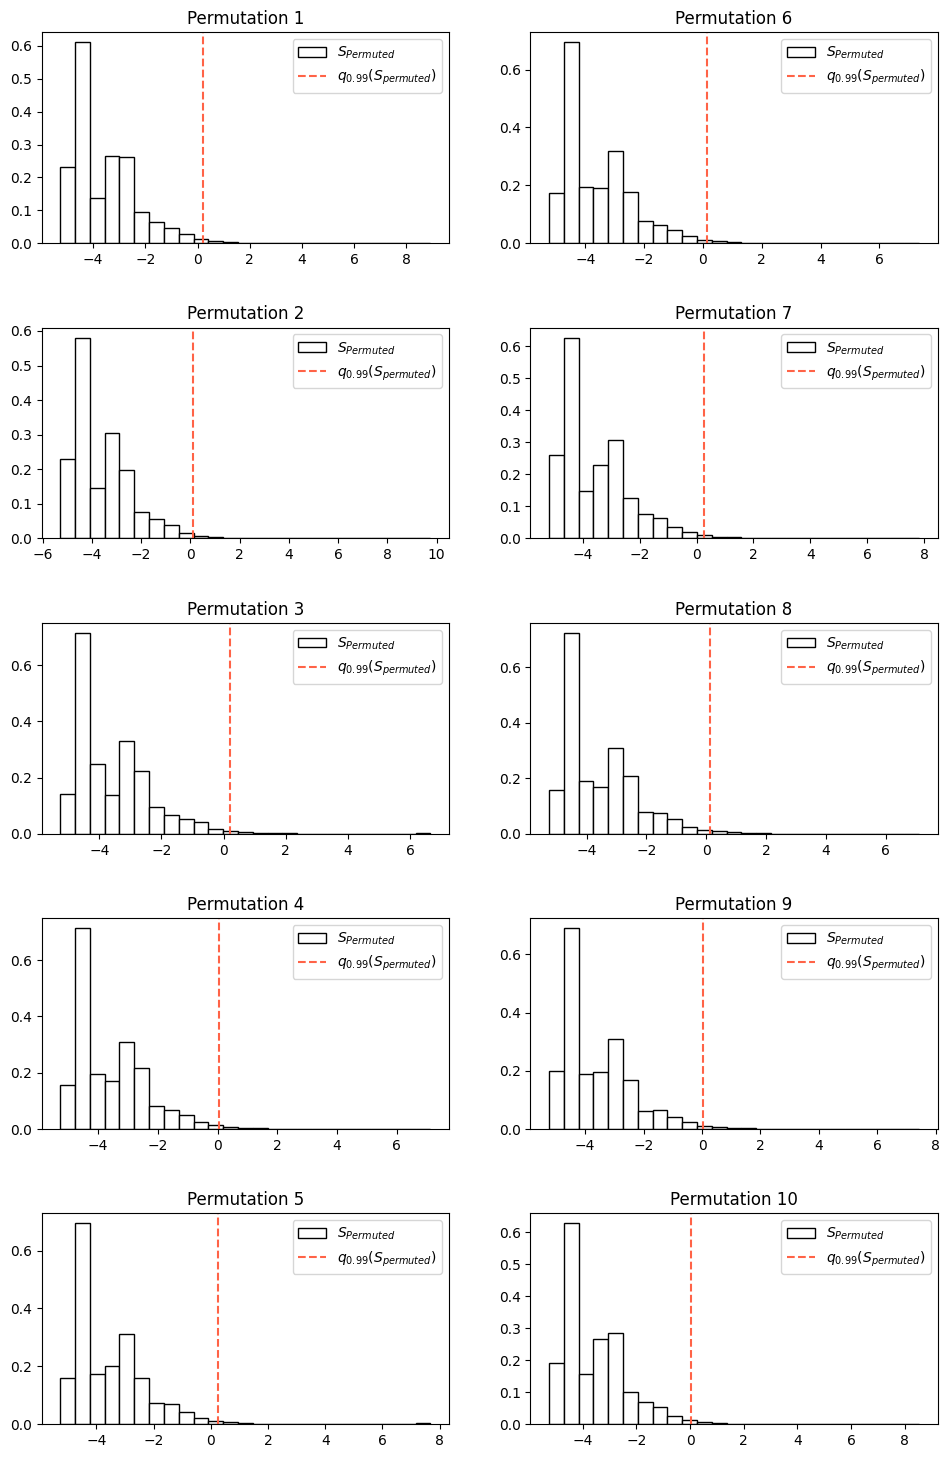

In [11]:
plt.figure(figsize=(20,24))
figure, axis = plt.subplots(5, 2) 

for i in range(10):
    loc_y = i // 5
    loc_x = i % 5
    name = f'permutation_{i}'
    sub_df = df.query('permutation == @name')
    replacement_score = sub_df[sub_df.value != float('+inf')].value.max() 
    sub_df = sub_df.replace(float('+inf'), replacement_score + 1)
    axis[loc_x, loc_y].hist(sub_df.value, density=True, bins=25, fill=True, ec="black", color='white', label='$S_{Permuted}$')
    axis[loc_x, loc_y].axvline(np.quantile(sub_df.value, 0.99), ls='--', color='tomato', label='$q_{0.99} (S_{permuted})$')
    axis[loc_x, loc_y].legend()
    axis[loc_x, loc_y].set_title(f"Permutation {i + 1}") 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=3, 
                    wspace=0.2, 
                    hspace=0.4)
# plt.show() 
plt.savefig('../data_autographiviridae_meta/pics/replicates_hist_only_permuted.png', dpi=300, bbox_inches='tight')

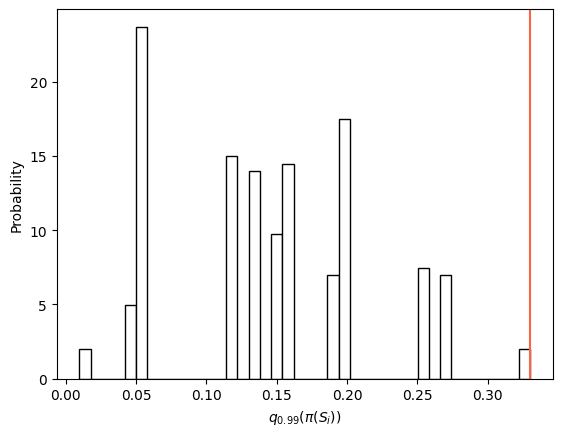

In [12]:
replacement_score = scores_df_melted_perm[scores_df_melted_perm.value != float('+inf')].value.max() 
scores_df_melted_perm_replaced = scores_df_melted_perm.replace(float('+inf'), replacement_score + 1)

plt.hist(nf_qua_values, density=True, bins=40, fill=True, ec="black", color='white')  # density=False would make counts
plt.axvline(np.quantile(nf_qua_values, 0.99), color='tomato')
plt.ylabel('Probability')
plt.xlabel('$q_{0.99}(\pi (S_i))$');

# #4. Select threshold

Threshold: such value that only 0.01 of permuted $q_{0.91}$ more than that threshold:

In [13]:
np.quantile(nf_qua_values, 0.99)

0.33041385398752404

# #5. Calculate observed scores and select significant based on permuted threshold

## #5.1. Read GFF and calculate similarities

In [14]:
# calculate scores
gff_df = read_gff(data_path)
loci_df = gff_df[['seq_id', 'ATTRIBUTE_clan']]
scores_df = get_similarity_scores(loci_df)
scores_df_melted = scores_df.melt(ignore_index=False)
scores_df_melted = scores_df_melted[scores_df_melted.seq_id != scores_df_melted.index]

## #5.2. Visualize distribution

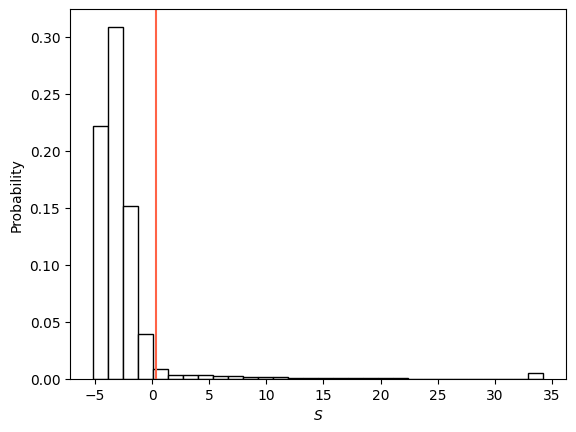

In [15]:
replacement_score = scores_df_melted[scores_df_melted.value != float('+inf')].value.max() 
scores_df_melted_replaced = scores_df_melted.replace(float('+inf'), replacement_score + 1)

plt.hist(scores_df_melted_replaced.value, density=True, bins=30, fill=True, ec="black", color='white')  # density=False would make counts
plt.axvline(np.quantile(nf_qua_values, 0.99), color='tomato')
plt.ylabel('Probability')
plt.xlabel('$S$');

## #5.3. Write results

In [14]:
# write results
# scores_df_melted[scores_df_melted.value >= np.quantile(nf_qua_values, 0.95)].loc[:, 'seq_id'].to_csv(out_file,
#                                                                                          sep='\t', header=False)


# #6. Analyse found communities

Based on calculated similarities, clustering of loci was performed with CL1.
It's time to analyse found loci communities.

Approach: find communities, loci of which contain the known ADGs. If some of the loci in such community does not have the known ADG, find which different proteins are encoded in this locus. 

## #6.0. Import packages

In [16]:
from collections import defaultdict

import pandas as pd
import networkx as nx

## #6.1. Read information about communities found

In [17]:
def read_clu1_res(in_path) -> tuple:
    clu2clans = defaultdict(list)
    with open(in_path, 'rt') as in_file:
        for i, line in enumerate(in_file):
            clan = line.strip().split('\t')
            name = f'{i+1}_community'
            for cluster in clan:
                clu2clans[cluster].append(name)
    return clu2clans, i+1


def read_edgelist(in_path: str) -> nx.classes.graph.Graph:
    """
    reads the edgefile into the nx object (Graph)
    """
    g = nx.read_edgelist(in_path, delimiter='\t', create_using=nx.Graph, data=(("weight", float),))
    return g


def find_all_pairs(g, already_known_structures: dict, max_num_prev: int) -> tuple:
    """
    find all pairs of nodes in graph (aka components of size 2)
    """
    structures = already_known_structures.copy()
    counter = max_num_prev

    for component in nx.connected_components(g):
        if len(component) == 2:
            counter += 1
            for node in component:
                name = f'{counter}_pair'
                structures[node].append(name)
    return structures, counter

## #6.2. Define input parameters

In [18]:
in_gff = '../data_autographiviridae_meta/loci_similarity/early_with_clusters_no_onegene_contigs.gff'
in_clans = '../data_autographiviridae_meta/loci_similarity/loci_communities.tsv'
in_edges = '../data_autographiviridae_meta/loci_similarity/edge_list_loci.tsv'
out_path = '../data_autographiviridae_meta/loci_similarity/putative_adgs.tsv'

## #6.3. Read input data

### Read GFF

In [20]:
gff_df = read_gff(in_gff)
loci_df = gff_df[['seq_id', 'ATTRIBUTE_clan']]
loci_df = loci_df.groupby('seq_id').apply(lambda x: frozenset(x['ATTRIBUTE_clan']))
loci_df = pd.DataFrame(loci_df, columns=['clans'])

loci_df.head()

,clans
seq_id,
Broecker_Sample_ID29-1191-3_NODE_102_length_38363_cov_11.011251,"(1_clan, outlier: 34_clan, 421_mono, 5_clan, 1..."
ERS698680|NODE_23_length_11647_cov_8.695997,"(137_pair, 1_clan)"
ERS698777|NODE_7_length_43252_cov_47.221080,"(83_clan, outlier, outlier: 14_clan, 1_clan, 4..."
ERS698786|NODE_3_length_76173_cov_1678.751649,"(883_mono, 402_mono, outlier: 7_clan, 576_mono..."
ERS743392|NODE_299_length_16723_cov_6.762599,"(1_clan, 502_mono, 1206_mono, 916_mono, 974_mono)"


### Read results of ClusterONE

In [21]:
graph = read_edgelist(in_edges)

structures, max_struct = read_clu1_res(in_clans)
structures, max_struct = find_all_pairs(graph, structures, max_num_prev=max_struct)

### Save updates info for CytoScape

In [22]:
def get_jaccard_distance(set_1: set, set_2: set) -> float:
    dist = len(set_1 & set_2) / len(set_1 | set_2)
    return dist

In [23]:
# append singletons
nodes_in_graph = set(graph.nodes)
edges_df = pd.DataFrame(graph.edges)
edges_df['Jaccard_dist'] = edges_df.apply(lambda x: get_jaccard_distance(loci_df.loc[x[0]].clans, loci_df.loc[x[1]].clans), axis=1)

In [24]:
edges_df = pd.concat([edges_df, pd.DataFrame({0: list(set(loci_df.index) - nodes_in_graph)})], ignore_index=True)

In [25]:
# find number of singletons
len(set(loci_df.index) - nodes_in_graph)

21

In [26]:
# save edgelist with singletons added
# edges_df.to_csv('../data_autographiviridae_meta/loci_similarity/edge_list_loci_updated.tsv', index=False, header=False, sep='\t')

In [27]:
# calculate loci sizes, which will be represented by size of point in network
loci_df['loc_size'] = loci_df['clans'].apply(lambda x: len(x))
# loci_df.to_csv('../data_autographiviridae_meta/loci_similarity/loci_sizes.tsv', sep='\t')

In [28]:
def fix_overlaps(clu2clans: dict) -> dict:
    clans = {}
    for cluster in clu2clans.keys():
        if len(clu2clans[cluster]) > 1:
            clans[cluster] = '; '.join([clan_name for clan_name in clu2clans[cluster]])
        else:
            clans[cluster] = clu2clans[cluster][0]
    return clans


def mark_outliers(g, already_known_structures: dict) -> dict:
    """
    marks outliers and bridges in graph which are not in communities,
    based ou their neighborhood
    """
    structures = already_known_structures.copy()
    for node in g.nodes():
        if node not in structures.keys():
            outlier_neighbors = []
            for neighbor in g.neighbors(node):
                if neighbor in structures.keys():
                    outlier_neighbors.append(structures[neighbor][0])
                else:
                    outlier_neighbors.append('outlier')

            if 'outlier' in outlier_neighbors:
                for nei in outlier_neighbors:
                    if nei.endswith('community'):
                        structures[node].append(f'outlier: {nei}')
                        break
                    else:
                        structures[node].append('outlier')
            elif all([nei.endswith('community') for nei in outlier_neighbors]):
                if len(outlier_neighbors) == 1:
                    structures[node].append(f'outlier: {outlier_neighbors[0]}')
                else:
                    structures[node].append(f'bridge: {", ".join(set(outlier_neighbors))}')
    return structures


def mark_lonely_clusters(clusters_mono: set, already_known_structures: dict, max_num_prev: int) -> dict:
    """
    mark clusters that does not form any structures (do not form a clans or even pairs), stand alone in the graph
    """
    counter = max_num_prev
    structures = already_known_structures.copy()
    for cluster in clusters_mono:
        if cluster not in structures.keys():
            counter += 1
            structures[cluster].append(f'{counter}_mono')
    return structures


def write_clusters(out_path: str, clu2clans: dict, fmt: str) -> None:
    if fmt == 'wide':
        with open(out_path, 'wt') as out_file:
            for pair in clu2clans.items():
                out_file.write('\t'.join(pair))
                out_file.write('\n')
    else:
        with open(out_path, 'wt') as out_file:
            for clu, info in clu2clans.items():
                for item in info:
                    out_file.write('\t'.join([clu, item]))
                    out_file.write('\n')



In [29]:
# get info about outliers in graph
structures = mark_outliers(graph, structures)
structures = mark_lonely_clusters(set(loci_df.index) - nodes_in_graph, structures, max_struct)
# save communities into a separatew table, will be represented as colors
structures_wide = fix_overlaps(structures)

# write_clusters('../data_autographiviridae_meta/loci_similarity/parsed_communities_info.tsv', structures_wide, fmt='wide')


In [30]:
structures_direct = defaultdict(set)
for seq_id, values in structures.items():
    for structure in values:
        structures_direct[structure].add(seq_id)

In [31]:
# save information about presence of ADGs in loci, will be shown by node shape in the network
# gff_df[['seq_id', 'ATTRIBUTE_clan']][gff_df.ATTRIBUTE_clan.isin(known_adgs)].to_csv('../data_autographiviridae_meta/loci_similarity/has_adgs.tsv',
#                                                                                    index=False, sep='\t')

has_adgs_df = gff_df[['seq_id', 'ATTRIBUTE_clan']][gff_df.ATTRIBUTE_clan.isin(known_adgs)]

In [32]:
# create list of tuples
structures_long = []
for comm, seq_ids in structures_direct.items():
    for seq_id in seq_ids:
        structures_long.append((comm, seq_id))

In [33]:
# create df from list
structures_df = pd.DataFrame(structures_long, columns=['structure', 'seq_id'])

In [34]:
str_agg_df = structures_df.groupby('structure').count()
sum(str_agg_df.index.str.endswith('community')) - sum(str_agg_df.index.str.startswith('bridge')) - sum(str_agg_df.index.str.startswith('outlier'))

57

In [35]:
sum(str_agg_df.index.str.endswith('mono'))

21

In [36]:
sum(str_agg_df.index.str.startswith('outlier'))

8

## #6.4. Find putative ADGs

In [37]:
# known_adgs = ['107_clan', '67_clan', '148_pair', '1314_mono']
# known_htgs = ['56_clan', '34_clan', '163_pair', '178_pair', '505_mono', '217_pair', '1272_mono']
# known_adgs_and_htgs = known_adgs + known_htgs

# to reduce noise, use only Ocr and SAMase 
known_adgs_and_htgs = ['107_clan', '67_clan']
has_adgs_and_htgs = gff_df[['seq_id', 'ATTRIBUTE_clan']][gff_df.ATTRIBUTE_clan.isin(known_adgs_and_htgs)]['seq_id'].to_list()

In [38]:
has_adgs = gff_df[['seq_id', 'ATTRIBUTE_clan']][gff_df.ATTRIBUTE_clan.isin(known_adgs_and_htgs)]['seq_id'].to_list()

In [39]:
len(has_adgs)

86

In [40]:
novel = {}
structures_with_known = set()
loci_within_comm_with_known = set() 
for str_name, structure in structures_direct.items():
    subset_loci = loci_df[loci_df.index.isin(structure)]
    subset_loci_adgs = subset_loci[subset_loci.index.isin(has_adgs_and_htgs)]
    if len(subset_loci_adgs) != 0:
        structures_with_known.add(str_name)
        loci_within_comm_with_known = loci_within_comm_with_known | structure
        print(f'{str_name} has known')
        subset_adgs_associated = {el for locus in subset_loci_adgs.clans.unique() for el in locus}
        subset_loci_no_adgs = subset_loci[~subset_loci.clans.isin(subset_adgs_associated)]
        novel_adgs = {e for l in subset_loci_no_adgs.clans.unique() for e in l} - subset_adgs_associated 
        novel[str_name] = novel_adgs

3_community has known
7_community has known
bridge: 7_community has known


In [41]:
structures_with_known

{'3_community', '7_community', 'bridge: 7_community'}

In [39]:
# filtered_genomes_out_file = '../data_autographiviridae_meta/loci_similarity/communities_with_known_adgs_htgs.id'
# with open(filtered_genomes_out_file, 'wt') as f:
#     f.write('\n'.join(loci_within_comm_with_known))

In [42]:
for i in structures_with_known:
    print(f'{i}: {novel[i]}')

3_community: {'1310_mono', '292_mono', '56_clan', '867_mono', '1246_mono', '1174_mono', '1264_mono', '757_mono', '1273_mono', '202_pair', '124_pair', '1335_mono', '1108_mono', '97_clan', '570_mono'}
7_community: {'124_pair'}
bridge: 7_community: set()


In [43]:
novel["7_community"]

{'124_pair'}

In [44]:
gff_df[gff_df['ATTRIBUTE_clan'].isin(novel["7_community"])].groupby('ATTRIBUTE_clu').count().sort_values('start')

,seq_id,source,type,start,end,score,strand,phase,ATTRIBUTE_ID,ATTRIBUTE_PFAM,ATTRIBUTE_prelim_info,ATTRIBUTE_clan
ATTRIBUTE_clu,,,,,,,,,,,,
4601,1,1,1,1,1,1,1,1,1,0,1,1
6815,3,3,3,3,3,3,3,3,3,0,3,3


In [45]:
gff_df

,seq_id,source,type,start,end,score,strand,phase,ATTRIBUTE_ID,ATTRIBUTE_PFAM,ATTRIBUTE_prelim_info,ATTRIBUTE_clu,ATTRIBUTE_clan
0,MGV-GENOME-0276608,PHANOTATE,CDS,16935,19655,-329065679379797.06,-,0,MGV-GENOME-0276608.16935,"PF14700.9,PF00940.22",nan,7905,1_clan
1,MGV-GENOME-0276608,PHANOTATE,CDS,19727,20731,-37179.9753,-,0,MGV-GENOME-0276608.19727,NaN,nan,4877,34_clan
2,MGV-GENOME-0276608,PHANOTATE,CDS,20766,20999,-3.7228,-,0,MGV-GENOME-0276608.20766,NaN,nan,71,408_mono
3,MGV-GENOME-0276608,PHANOTATE,CDS,20983,21180,-18.0055,-,0,MGV-GENOME-0276608.20983,NaN,nan,8282,56_clan
4,MGV-GENOME-0276608,PHANOTATE,CDS,21158,21304,-3.2176,-,0,MGV-GENOME-0276608.21158,NaN,nan,4687,"38_clan, 56_clan"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8424,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,PHANOTATE,CDS,4178,4585,-2.7831,+,0,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,NaN,nan,4177,17_clan
8425,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,PHANOTATE,CDS,4596,4688,-4.9517,+,0,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,NaN,nan,1841,59_clan
8426,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,PHANOTATE,CDS,4727,7195,-2108326688856.7007,+,0,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,"PF14700.9,PF00940.22",nan,6901,1_clan
8427,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,PHANOTATE,CDS,43380,43488,-10.8297,+,0,Han_2018_ERR1398150_NODE_58_length_43653_cov_1...,NaN,nan,3818,86_clan


# Sandbox

Compare distributions (observed with one of the permutation)

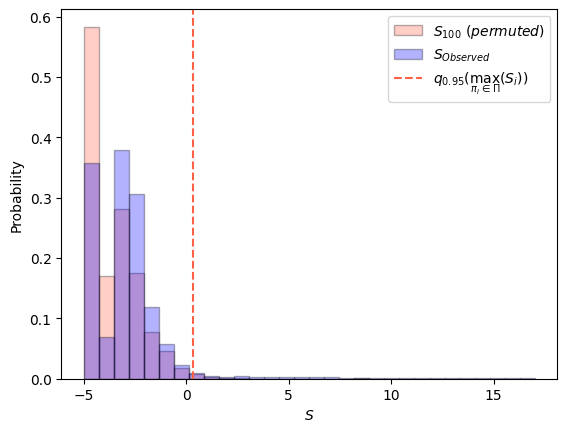

In [46]:
plt.hist(scores_df_melted_perm_replaced.value, alpha=0.3, density=True, bins=30, fill=True, range=[-5, 17], ec="black", color='tomato', label='$S_{100}\ (permuted)$') 
plt.hist(scores_df_melted_replaced.value, alpha=0.3, density=True, bins=30, fill=True, ec="black",  range=[-5, 17], color='blue', label='$S_{Observed}$')
plt.axvline(nf_qua_values.max(), ls='--', color='tomato', label='$q_{0.95} (\max_{\pi_i \in \Pi}(S_i) )$')
plt.legend(loc='upper right')  
plt.ylabel('Probability')
plt.xlabel('$S$');

#### Try use rugplot

In [47]:
nf_qua_values_df = pd.DataFrame({'permuted_q99': nf_qua_values})
# np.quantile(nf_qua_values, 0.99)

In [48]:
nf_qua_values_df

,permuted_q99
0,0.192120
1,0.116097
2,0.195726
3,0.049824
4,0.253494
...,...
495,0.133386
496,0.049824
497,0.049824
498,0.133386


<Axes: xlabel='permuted_q99'>

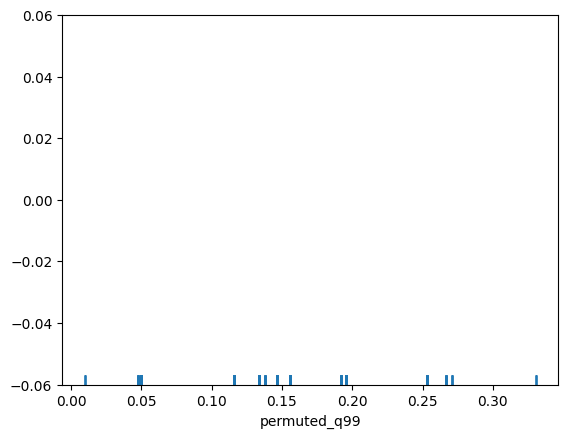

In [49]:
sns.rugplot(data=nf_qua_values_df, x="permuted_q99")

<Axes: xlabel='value', ylabel='Density'>

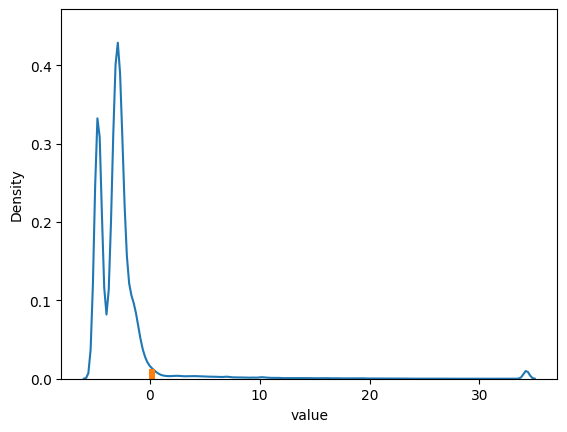

In [50]:
sns.kdeplot(data=scores_df_melted_replaced, x="value")
sns.rugplot(data=nf_qua_values_df, x="permuted_q99")

Compare a set of permutations

<Figure size 2000x2400 with 0 Axes>

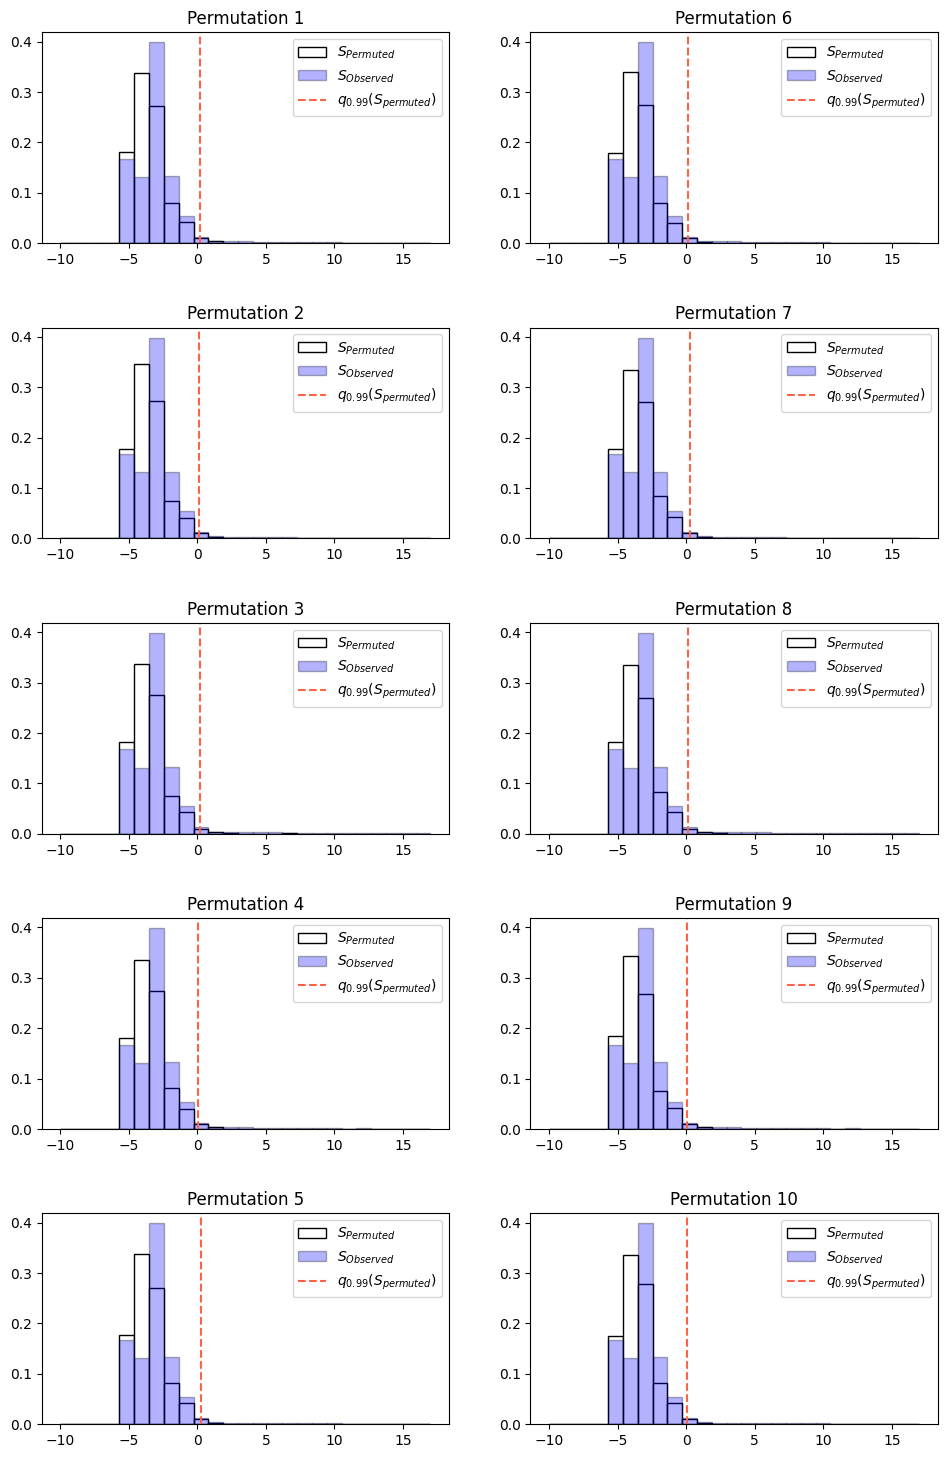

In [51]:
plt.figure(figsize=(20,24))
figure, axis = plt.subplots(5, 2) 

for i in range(10):
    loc_y = i // 5
    loc_x = i % 5
    name = f'permutation_{i}'
    sub_df = df.query('permutation == @name')
    replacement_score = sub_df[sub_df.value != float('+inf')].value.max() 
    sub_df = sub_df.replace(float('+inf'), replacement_score + 1)
    axis[loc_x, loc_y].hist(sub_df.value, density=True, bins=25, fill=True,  range=[-10, 17], ec="black", color='white', label='$S_{Permuted}$')
    axis[loc_x, loc_y].hist(scores_df_melted_replaced.value, alpha=0.3, density=True, bins=25, fill=True, ec="black",  range=[-10, 17], color='blue', label='$S_{Observed}$')
    axis[loc_x, loc_y].axvline(np.quantile(sub_df.value, 0.99), ls='--', color='tomato', label='$q_{0.99} (S_{permuted})$')
    axis[loc_x, loc_y].legend()
    axis[loc_x, loc_y].set_title(f"Permutation {i + 1}") 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=3, 
                    wspace=0.2, 
                    hspace=0.4)
# plt.show() 
plt.savefig('../data_autographiviridae_meta/pics/replicates_hist.png', dpi=300, bbox_inches='tight')

In [52]:
# Make sample first

gff_df[['seq_id', 'ATTRIBUTE_clan']]
sample = np.random.choice(gff_df.seq_id.unique(), 100)
gff_df.query('seq_id in @sample') 

,seq_id,source,type,start,end,score,strand,phase,ATTRIBUTE_ID,ATTRIBUTE_PFAM,ATTRIBUTE_prelim_info,ATTRIBUTE_clu,ATTRIBUTE_clan
124,MGV-GENOME-0340861,PHANOTATE,CDS,31275,33155,-2.929427032264066e+17,-,0,MGV-GENOME-0340861.31275,PF00940.22,nan,385,"1_clan, 2_clan, 13_clan"
125,MGV-GENOME-0340861,PHANOTATE,CDS,33118,33498,-149.2085,-,0,MGV-GENOME-0340861.33118,NaN,nan,7687,363_mono
126,MGV-GENOME-0340861,PHANOTATE,CDS,33624,33806,-4.5216,-,0,MGV-GENOME-0340861.33624,NaN,nan,7951,873_mono
127,MGV-GENOME-0340861,PHANOTATE,CDS,33800,33976,-108.1108,-,0,MGV-GENOME-0340861.33800,NaN,nan,8215,1256_mono
128,MGV-GENOME-0340861,PHANOTATE,CDS,33987,34115,-2.347,-,0,MGV-GENOME-0340861.33987,NaN,nan,4,1367_mono
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8376,MGV-GENOME-0198224,PHANOTATE,CDS,12391,12765,-105.2794,-,0,MGV-GENOME-0198224.12391,NaN,nan,4781,220_pair
8377,MGV-GENOME-0198224,PHANOTATE,CDS,12870,13025,-6.9513,-,0,MGV-GENOME-0198224.12870,NaN,nan,2383,66_clan
8378,MGV-GENOME-0198224,PHANOTATE,CDS,13078,13911,-3024.1532,-,0,MGV-GENOME-0198224.13078,NaN,nan,6574,9_clan
8379,MGV-GENOME-0198224,PHANOTATE,CDS,13967,14146,-7.1833,-,0,MGV-GENOME-0198224.13967,NaN,nan,3818,86_clan


##### export communities data

In [53]:
long_list = pd.read_csv('../data_autographiviridae_meta/clans_info/res_table_long.tsv', sep='\t')
long_list.head()

,clu,prot,prelim_info,phrog,annot,phrog_category,pfam_dom,pfam_id,apis,dbapis_clan_id,apis_genes,defense_systems,seq,length,pi,clan
0,1275,SRS018573_a1_ct23703_vs1@Podoviridae__sp._ct5q...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VGCEVHELPRYQGLAEAAPGLLGAAPEAVHLPLPQD*,37,4.56,1338_mono
1,3457,MGV-GENOME-0150089.17563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIRYSHRQGDSANAFPSRKNFNLLRSDKSLQTKGGKENGNYNS*,44,10.28,192_pair
2,321,MGV-GENOME-0267293.5705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFPIDRDTLETYIAMGMFHGLCLAVSLFIAWLLFWIIGGCK*,42,5.36,106_clan
3,321,MGV-GENOME-0268032.34655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFPIDRDTLETYIAIGMFHGLCLVVSLFIAWLLFWIIGGCK*,42,5.36,106_clan
4,321,MGV-GENOME-0263392.34117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFPIDKDTLETYIAMGMFHGLCLAVSLFIAWLLFWIIGGCK*,42,5.36,106_clan


In [54]:
t3t7_hits = pd.read_csv('../data_autographiviridae_meta/mmseqs_dbs/t3_and_t7/homologs.m8', sep='\t',
           names = ['prot', 't3t7_hit', 'seqid', 'nmatch', 'nmmatch', 'ngap', 'smth', 'smth2', 'smth3', 'smth4', 'eval', 'bitscore'])
t3t7_hits = t3t7_hits.iloc[t3t7_hits.groupby('t3t7_hit').eval.idxmin()]
t3t7_hits = t3t7_hits[['prot', 't3t7_hit']]

In [55]:
long_refseq = pd.read_csv('../data_autographiviridae_refseq/clans_info/res_table_long.tsv', sep='\t')
t3t7_hits = t3t7_hits.set_index('t3t7_hit').join(long_refseq[long_refseq['prelim_info'].notna()][['prot', 'prelim_info']].set_index('prot'))

In [56]:
t3t7_hits = t3t7_hits.reset_index().set_index('prot')
t3t7_hits

,t3t7_hit,prelim_info
prot,,
MGV-GENOME-0265351.35049,NC_001604.1.1278,Ocr
MGV-GENOME-0263483.5122,NC_001604.1.1433,T7p0.4
MGV-GENOME-0265351.35398,NC_001604.1.1639,T7p0.5
MGV-GENOME-0263483.5787,NC_001604.1.1797,T7p0.6A
MGV-GENOME-0263483.5989,NC_001604.1.1972,T7p0.6B
SRR7892431_NODE_5_length_39514_cov_32.711067.14971,NC_001604.1.3100,T7pSTPK
Zuo_2017_SRR5677784_NODE_194_length_16760_cov_1674.172344.1540,NC_003298.1.1359,SAMase
Zuo_2017_SRR5677784_NODE_194_length_16760_cov_1674.172344.2197,NC_003298.1.1627,T3p0.6
Zuo_2017_SRR5677784_NODE_194_length_16760_cov_1674.172344.2354,NC_003298.1.1781,T3p0.65


In [57]:
prelim = long_list.drop(columns=['prelim_info']).set_index('prot').join(t3t7_hits)
prelim

,clu,phrog,annot,phrog_category,pfam_dom,pfam_id,apis,dbapis_clan_id,apis_genes,defense_systems,seq,length,pi,clan,t3t7_hit,prelim_info
prot,,,,,,,,,,,,,,,,
SRS018573_a1_ct23703_vs1@Podoviridae__sp._ct5qv1.38055,1275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VGCEVHELPRYQGLAEAAPGLLGAAPEAVHLPLPQD*,37,4.56,1338_mono,NaN,NaN
MGV-GENOME-0150089.17563,3457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIRYSHRQGDSANAFPSRKNFNLLRSDKSLQTKGGKENGNYNS*,44,10.28,192_pair,NaN,NaN
MGV-GENOME-0267293.5705,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFPIDRDTLETYIAMGMFHGLCLAVSLFIAWLLFWIIGGCK*,42,5.36,106_clan,NaN,NaN
MGV-GENOME-0268032.34655,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFPIDRDTLETYIAIGMFHGLCLVVSLFIAWLLFWIIGGCK*,42,5.36,106_clan,NaN,NaN
MGV-GENOME-0263392.34117,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFPIDKDTLETYIAMGMFHGLCLAVSLFIAWLLFWIIGGCK*,42,5.36,106_clan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGV-GENOME-0348822.67189,2701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MNAKEALLMLKLGAVIRRPRWNSGTLLTLNHKGEILVRFSDGDIYT...,70,6.03,outlier: 7_clan,NaN,NaN
SAMN00791913_a1_ct1999@circular@Podoviridae__sp._ctuqh999.2947,2701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MNAKEALLMLKLGAVIRRPRWNSGTLLTLNHKGEILITFSDGDVYT...,70,6.03,outlier: 7_clan,NaN,NaN
MGV-GENOME-0349583.55307,2701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVHYMTGKEALLMLKLGAVIRRPIWNRGTLLTLDHNGQIFVRYSDG...,74,6.82,outlier: 7_clan,NaN,NaN


In [58]:
prelim[prelim['prelim_info'].notna()]['prelim_info']

prot
Zuo_2017_SRR5677784_NODE_194_length_16760_cov_1674.172344.1540     SAMase
MGV-GENOME-0265351.35049                                              Ocr
MGV-GENOME-0263483.5122                                            T7p0.4
Zuo_2017_SRR5677784_NODE_194_length_16760_cov_1674.172344.2197     T3p0.6
MGV-GENOME-0263483.5787                                           T7p0.6A
Zuo_2017_SRR5677784_NODE_194_length_16760_cov_1674.172344.2354    T3p0.65
MGV-GENOME-0265351.35398                                           T7p0.5
SRR7892431_NODE_5_length_39514_cov_32.711067.14971                T7pSTPK
Zuo_2017_SRR5677784_NODE_194_length_16760_cov_1674.172344.3478    T3pSTPK
MGV-GENOME-0263483.5989                                           T7p0.6B
Name: prelim_info, dtype: object